In [1]:
import os
import sys
sys.path.append('../')

In [ ]:
%matplotlib inline
from argparse import ArgumentParser
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal 
from visualmic.sound_from_video import sound_from_video
from visualmic.sound_spectral_subtraction import get_soud_spec_sub
from functools import reduce
import itertools
import pandas as pd
from os import path
import numpy as np

In [4]:
def parametersTuning(model_call, params):
    '''
    This function return a pandas Dataframe of Tuning parameters, 
    the APIs are inspired by The Talos library.
    
    X: input data
    Y: label data
    modell_call: It is a callback that must create model and do fit, look at the functions above
    X_dev: input data test
    Y_dev: label data test
    '''
    # Calculate the number of combinations
    num_combin = reduce(lambda x,y: x*y, list(map(lambda x: len(x), params.values())))
    print ('Total combinations:', num_combin)
    # Headers of model
    headers = list(params.keys())
    append_model_header = True
    # List of model Values
    values = list()
    # Take list of params keys
    keys = list(params.keys())
    # Iterate over all combinations
    for combination in itertools.product(*params.values()):
        # Create a params combination
        assigned_params_combination = {keys[i]:combination[i] for i in range(len(keys))}
        print(assigned_params_combination)
        dictionary = model_call(assigned_params_combination)
        
        if append_model_header and dictionary is not None:
            headers = list(dictionary.keys()) + headers
            append_model_header = False
            
        # Learn model with assigned params
        values.append(list(assigned_params_combination.values()) + list(dictionary.values()))
        # Update combinations variable
        num_combin -= 1
        print ('Remaining combinations:', num_combin)
    return pd.DataFrame(values, columns=headers)

In [ ]:

parameters = {
    'input_video': ['../chips_fra_martino.mp4', '../chips_song.mp4', '../chips_ramp.mp4'],
    'sampling_rate': [480],
    'nscale':[1, 2, 4],
    'norientation':[2, 4],
    'downsample_factor':[0.1, 0.25],
    'qtl': [0.5, 0.8]
}


def plot_specgram(x: np.array,  sr,file_path):
  plt.figure()
  plt.specgram(x, Fs=sr ,cmap=plt.get_cmap('jet'))
  plt.xlabel('Time (sec)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar().set_label('PSD (dB)')
  plt.savefig(file_path)


def save_audio(x: np.array, sr, output_file, file_suffix=''):
  dir, file = path.split(output_file)
  f_name, f_extension = path.splitext(file)

  wavfile.write(path.join(dir, f_name + file_suffix + f_extension), sr, x)
  return path.join(dir, f_name + file_suffix + f_extension)



def tuning_callback2(params, output='out.wav'):
    vr = cv.VideoCapture(params['input_video'])
    joined_str = '_'.join([str(i) if type(i) is not str else path.basename(i) for i in params.values()])

    sr = params['sampling_rate']
    df = params['downsample_factor']
    norien = params['norientation']
    nscale = params['nscale']
    
    x, x_nofilt, x_noalig = sound_from_video(vr, nscale, norien, downsample_factor=df, sampling_rate=sr) 

    plot_specgram(x,sr,output + joined_str + '.png')
    audio_path = save_audio(x, sr, output, joined_str)  
    x_specsub = get_soud_spec_sub(x)

    plot_specgram(x_specsub, sr, output + joined_str + '_specsub.png')
    audio_path_spec = save_audio(x_specsub, sr, output, joined_str + '_specsub')

    return {"audio": audio_path, 
            "spec_sub_audio": audio_path_spec, 
            "graph": output + joined_str + '_specsub.png', 
            "spec_sub_graph": output + joined_str + '_specsub.png'}

table = parametersTuning(tuning_callback2, parameters)
table.to_html('results.html')

Total combinations: 3
{'input_video': '../chips_fra_martino.mp4', 'sampling_rate': 480, 'nscale': 1, 'norientation': 2, 'downsample_factor': 1, 'qtl': 0.5}


In [9]:
  args = {
      "input_video": "../../VID_20200120_165221.mp4",
      "output" : "../../out" 
  }

vr = cv.VideoCapture(args['input_video'])
sr = round(vr.get(cv.CAP_PROP_FPS)) if  480 is None else 480
x, _ = sound_from_video(vr, 1, 2, downsample_factor=0.1, sampling_rate=sr)


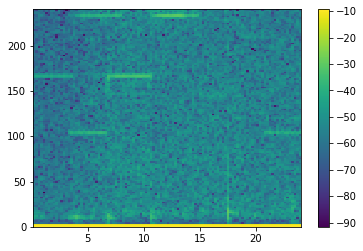

In [132]:

plt.figure()
plt.specgram(x, Fs=480, noverlap= 150)
plt.colorbar()
plt.show()

#wavfile.write(args.output, sr, x)

In [111]:
#wavfile.write(args['output'], sr, x)
def get_soud_spec_sub (x: np.array):
    _, _, st = signal.stft(x)
    # st is a tuple
    print(st.shape)

    
    stmags = np.multiply(np.abs(st), np.abs(st))
    print(stmags.shape)
    stangles = np.angle(st)
    print(stangles.shape)
    
    hold_col = np.quantile(stmags, 0.5, axis=1)
    print(hold_col.shape)
    
    for q in range(stmags.shape[1]):
        stmags[:, q] -= hold_col
        stmags [:, q] = np.maximum(stmags[:,q], 0)
    
    stmags = np.sqrt(stmags)
    newst = np.multiply(stmags, 1j * stangles)
    
    _, new_x = signal.istft(newst)
    
    maxsx = np.max(new_x)
    minsx = np.min(new_x)

    if maxsx != 1.0 or minsx != -1.0:
        rangesx = maxsx - minsx
        new_x = 2 * new_x / rangesx
        newmax = np.max(new_x)
        offset = newmax - 1.0
        new_x = new_x - offset
    
    return new_x
    
    
    
new_x = get_soud_spec_sub(x)


(129, 93)
(129, 93)
(129, 93)
(129,)


In [112]:
wavfile.write(args['output'] + "_denoising", sr, new_x)

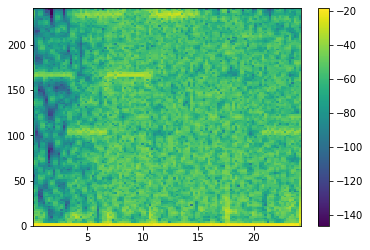

In [127]:

plt.figure()
plt.specgram(new_x, Fs=sr, noverlap= 150)
plt.colorbar()
plt.show()